# QuantEM Demo: Iceberg Code

This notebook demonstrates the QuantEM compiler's end-to-end workflow for applying Iceberg error detection to a QAOA circuit.

**Key Steps:**
1. **Circuit Generation** - Create a 6-qubit QAOA circuit for MaxCut
2. **QED Integration** - Apply Iceberg code with state preparation and syndrome measurement  
3. **Performance Evaluation** - Compare fidelity with and without error detection

**Iceberg Code**: A distance-2 quantum error detection code `[[k+2, k, 2]]` that requires only 2 additional qubits for any number of logical qubits. Ideal for trapped-ion systems with all-to-all connectivity.

In [1]:
from qiskit.circuit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    Instruction,
)

from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
)

from qiskit_aer import AerSimulator
from quantem.iceberg_code import build_iceberg_circuit

In [2]:
def generate_all_zz_terms(num_qubits: int) -> list:
    zz_terms = []
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            pauli = ['I'] * num_qubits
            pauli[i] = 'Z'
            pauli[j] = 'Z'
            zz_terms.append(''.join(pauli))
    return zz_terms

### **Step 1:** Generate QAOA circuit for MaxCut

In [3]:
#QAOA for MAXCUT 
num_qubits = 6
cost_hamiltonian = generate_all_zz_terms(num_qubits)
mixer_hamiltonian = ['XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX']
test_paulis = (cost_hamiltonian + mixer_hamiltonian)* 2
test_params = [3.271] * len(cost_hamiltonian) +   [2.874] * len(mixer_hamiltonian)  + [3.271] * len(cost_hamiltonian) +   [2.874] * len(mixer_hamiltonian) 

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZZGate
from typing import List
import numpy as np

def apply_pauli_rotation(qc: QuantumCircuit, pauli: str, angle: float):
    """Applies e^{-i angle * Pauli/2} for specific structured Paulis."""
    if pauli.count('Z') == 2 and all(p in 'IZ' for p in pauli):
        # Two-qubit ZZ term → RZZ
        idx = [i for i, p in enumerate(pauli) if p == 'Z']
        qc.rzz(2 * angle, idx[0], idx[1])

    elif pauli.count('X') == 1 and all(p in 'IX' for p in pauli):
        # Single-qubit X term → RX
        idx = pauli.index('X')
        qc.rx(2 * angle, idx)

    else:
        raise ValueError(f"Unsupported Pauli string: {pauli}")

def build_qaoa_from_paulis(paulis: List[str], params: List[float]) -> QuantumCircuit:
    n_qubits = len(paulis[0])
    qc = QuantumCircuit(n_qubits)

    # Initialize in |+>^n
    # qc.h(range(n_qubits))

    for pauli, angle in zip(paulis, params):
        apply_pauli_rotation(qc, pauli, angle)

    return qc

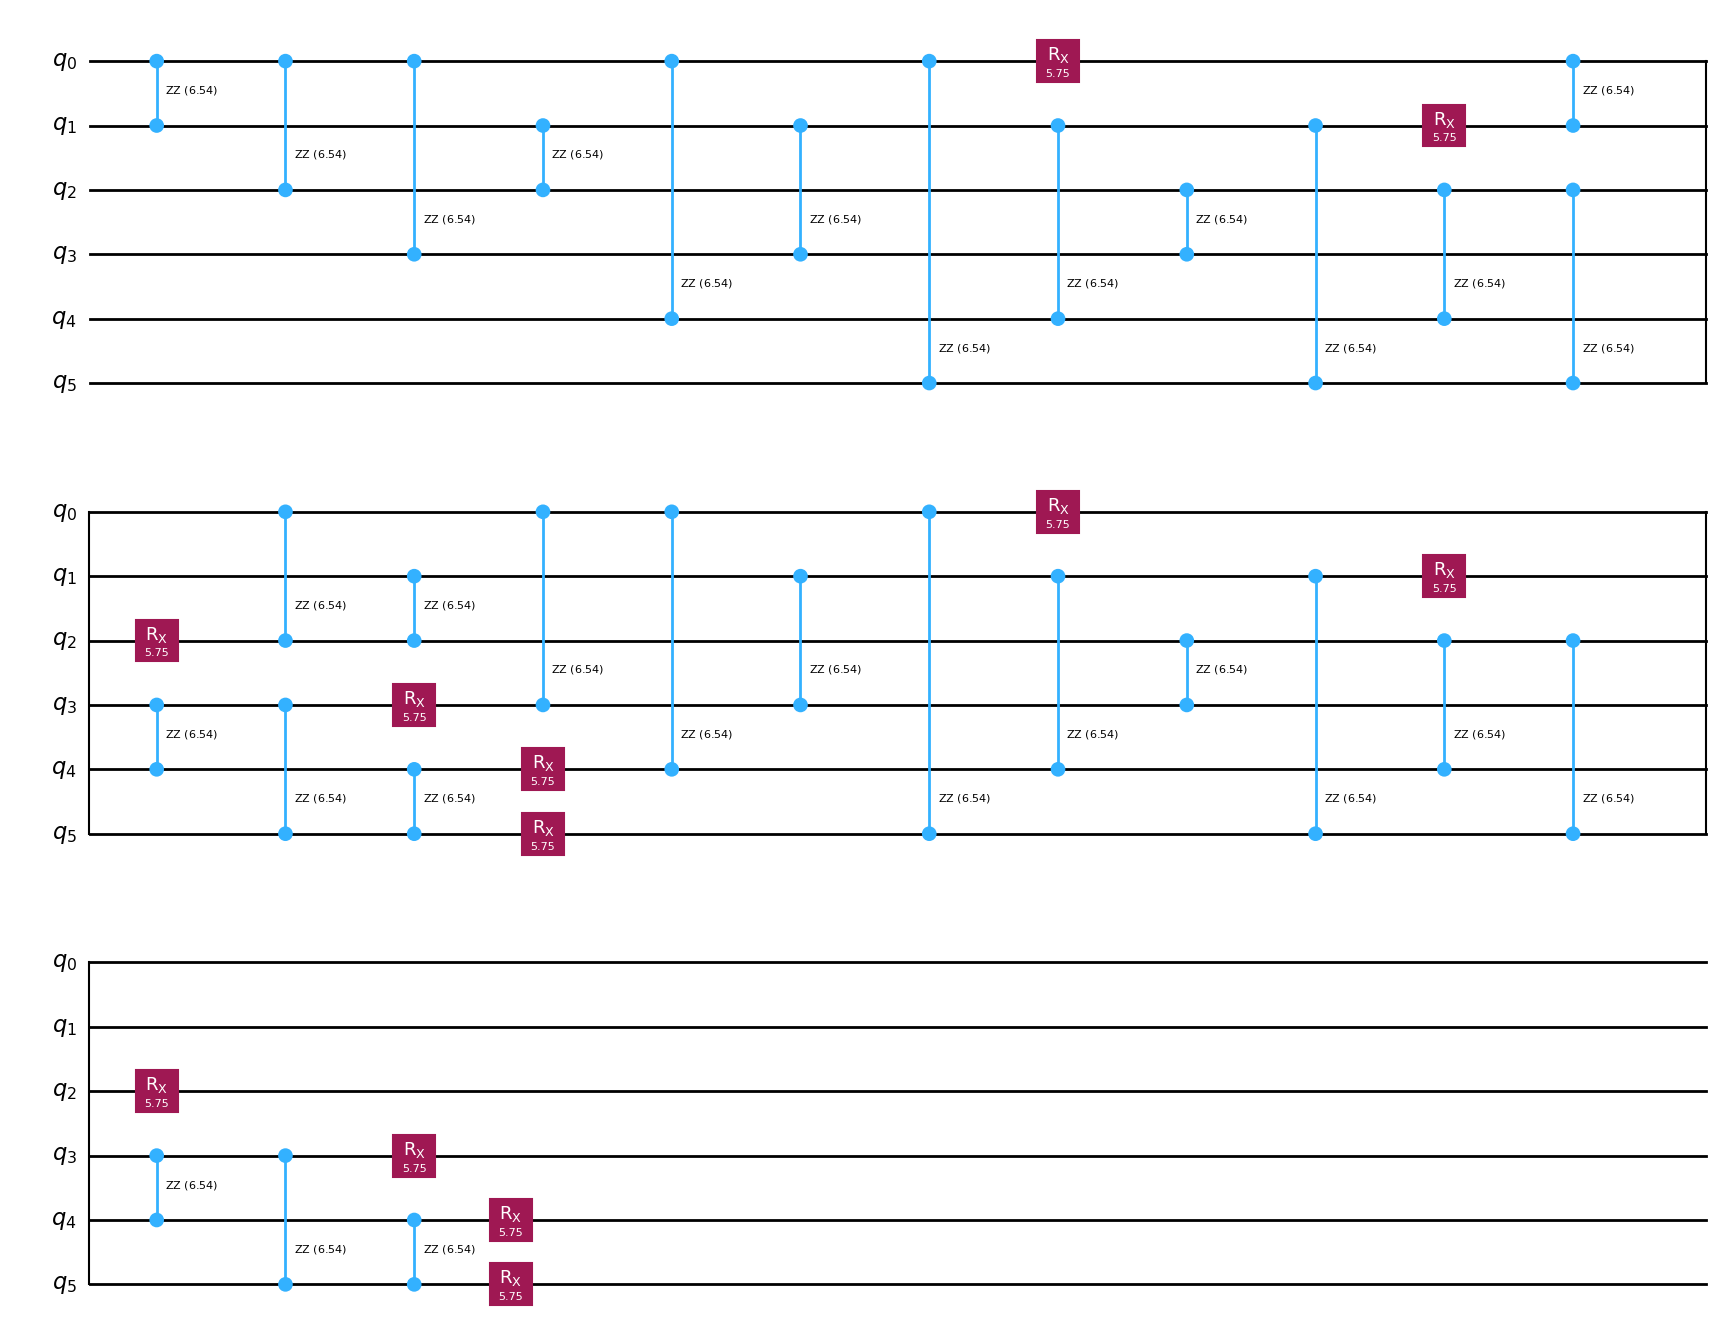

In [5]:
qc = build_qaoa_from_paulis(test_paulis, test_params)
qc.draw(output = 'mpl')

### **Step 2:** Apply Iceberg error detection

The Iceberg code creates an encoded state using 2 additional qubits (top and bottom) that connect to all logical qubits. Syndrome measurements occur at regular intervals to detect single-qubit errors.

In [6]:
qed_qc, reg_bundle = build_iceberg_circuit(
    qc,
    optimize_level=3,
    attach_readout=True,
    syndrome_interval = 10,
)

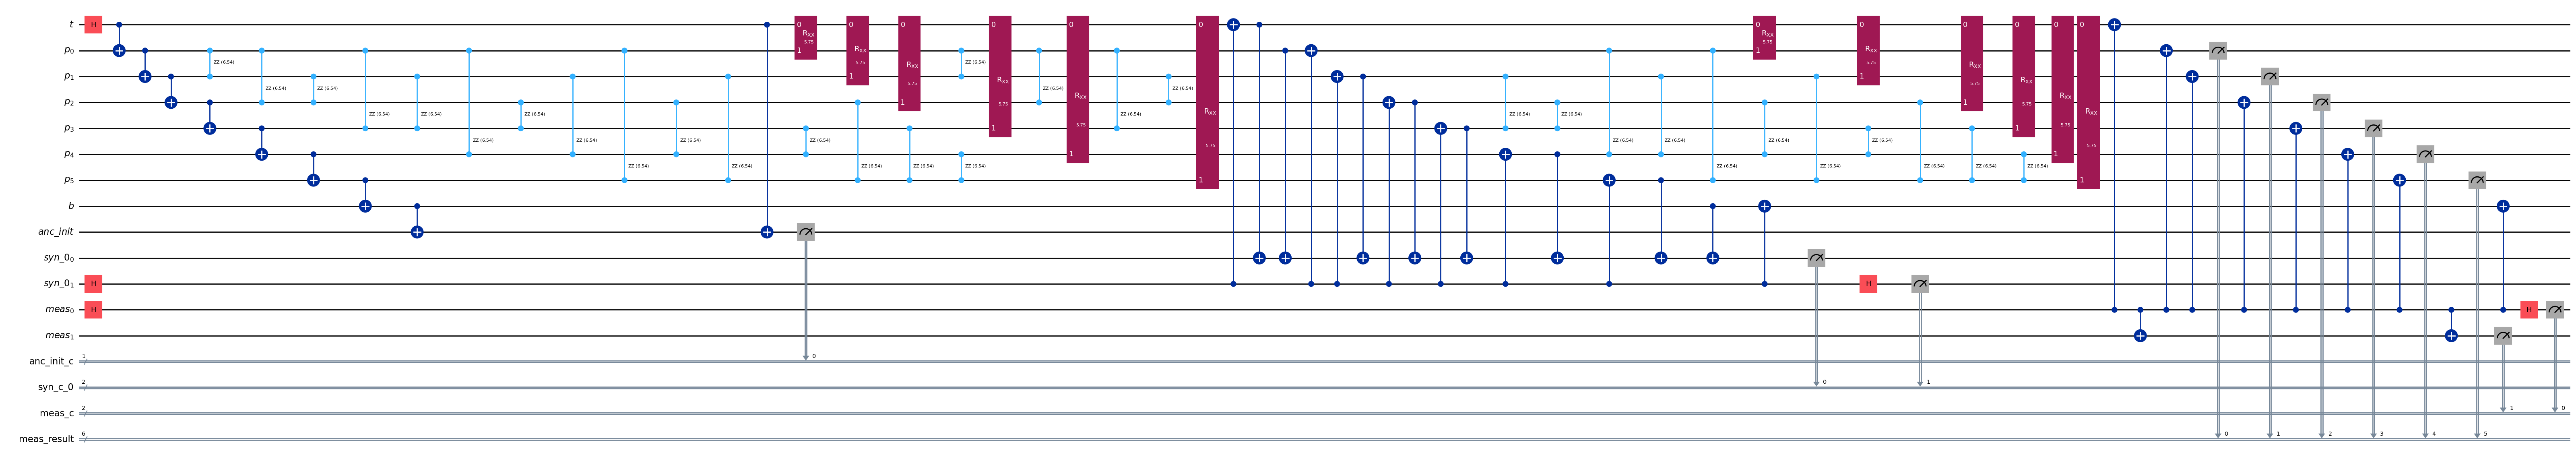

In [7]:
qed_qc.draw(output = "mpl", fold=-1)

### **Step 3:** Performance evaluation

In [8]:
def postselect_on_last_k_zeros(data: dict, n: int, k: int) -> dict:
    result = {}
    for key, count in data.items():
        # Split by whitespace and get the last k bits from the last block
        bits = ''.join(key.split())  # remove spaces for bitwise slicing
        if bits[-k:] == '0' * k:
            result[key[:n]] = count
    return result

In [9]:
#Run the original circuit on a noiseless simulator:
meas_qc = qc.copy()
meas_qc.measure_all()
simulator = AerSimulator()
ideal_results1 = simulator.run(meas_qc, shots = 100000).result()
ideal_dist1 = ideal_results1.get_counts()

In [10]:
#Run the original error detected circuit on a noiseless simulator:
simulator = AerSimulator()
ideal_results2 = simulator.run(qed_qc, shots = 100000).result()
ideal_dist2 = postselect_on_last_k_zeros(ideal_results2.get_counts(), num_qubits, 5)

### Create noise model and run noisy simulations

In [11]:
#Build noise model: 
noise_model = NoiseModel()
 
# Add depolarizing error to all single and two qubit gates single-qubit 99.997% and two qubit: 99.8%
error = depolarizing_error(0.002, 2)
noise_model.add_all_qubit_quantum_error(error, ["cx", "rzz", "rxx"])
error = depolarizing_error(0.00003, 1)
noise_model.add_all_qubit_quantum_error(error, ["rx", "rz", "h", 'u3'])

In [12]:
#simulating the original circuit on a noisy backend
noisy_simulator = AerSimulator(noise_model=noise_model)
noisy_result = noisy_simulator.run(meas_qc, shots = 100000).result()
noisy_dist = noisy_result.get_counts()

In [13]:
#simulating the error mitigated circuit on a noisy backend
noisy_simulator = AerSimulator(noise_model=noise_model)
mitigated_result = noisy_simulator.run(qed_qc, shots = 100000).result()
mitigated_dist = postselect_on_last_k_zeros(mitigated_result.get_counts(), num_qubits, 5)

### Compare results

In [ ]:
from qiskit.quantum_info import hellinger_fidelity

raw_fidelity = hellinger_fidelity(ideal_dist1, noisy_dist)
mitigated_fidelity = hellinger_fidelity(ideal_dist2, mitigated_dist)
postselection_rate = sum(mitigated_dist.values())/(sum(ideal_dist1.values()))

improvement = (mitigated_fidelity - raw_fidelity) / raw_fidelity * 100
overhead = (1 - postselection_rate) * 100

print("🎯 Iceberg QED Performance Summary")
print("=" * 35)
print(f"Raw fidelity:         {raw_fidelity:.6f}")
print(f"Iceberg fidelity:     {mitigated_fidelity:.6f}")
print(f"Relative improvement: {improvement:+.3f}%")
print(f"Overhead (discarded): {overhead:.1f}% of runs")
print()